## Project Thematic Area: Recommendation Systems

## **Group_3 Phase_4 Members**

```
Otiende Ogada
Lewis Ngunjiri
Ruth Nyakio
Sammy Warah
Bethuel Maruru
Lydia Masabarakiza



## Business Understanding
Showmax is a subscription-based video-on-demand service that aims to provide users with a wide variety of TV shows, movies, and original content for streaming over the internet. Its business revolves around offering entertainment content to subscribers, focusing on convenience, choice, and quality of viewing experience to attract and retain customers in a competitive digital streaming market.

### Objective:
Develop a personalized recommendation system to enhance user engagement and satisfaction on Showmax.

### Specific Task:
To build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

## Problem Statement:
Showmax aims to provide a tailored viewing experience by recommending top 5 movies to users based on their past ratings and viewing behaviors. 
The challenge is to build an effective recommendation model that accurately predicts user preferences, thereby increasing user retention and overall satisfaction with the platform.

## Import neccessary Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter 
import calendar
from dateutil import relativedelta
import operator
import os
import random
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
import matplotlib.ticker as ticker
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: f'%.{len(str(x%1))-2}f' % x)
pd.set_option('display.max_colwidth', None)
%matplotlib inline
from wordcloud import WordCloud

### Loading the datasets

In [2]:
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
tags_df = pd.read_csv('tags.csv')

1. ratings.csv:

* Contains user ratings for movies.
* Format: userId,movieId,rating,timestamp.
* Ratings are on a 5-star scale with half-star increments.
* Timestamps are in seconds since January 1, 1970 (UTC).

2. tags.csv:

* Contains user-generated tags for movies.
* Format: userId,movieId,tag,timestamp.
* Tags are single words or short phrases.
* Timestamps are in seconds since January 1, 1970 (UTC).

3. movies.csv:

* Contains movie information.
* Format: movieId,title,genres.
* Titles include release years in parentheses.
* Genres are pipe-separated from a predefined set of categories.



4.Key components of the dataset

User IDs: Identifies users.

Item IDs (Movie IDs): Identifies items (movies) that users interact with.

Ratings: The feedback (ratings) that users give to items (movies).

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Merging the datasets to form a master df

In [6]:
# Step 1: Merge movies_df with ratings_df on movieId
movies_ratings_df = pd.merge(movies_df, ratings_df, on='movieId')

print(movies_ratings_df.shape)

(100836, 6)


In [7]:
# Step 2: Merge movies_ratings_df with tags_df on movieId and userId to ensure all the tags are matched to right user and movie
master_df = pd.merge(movies_ratings_df, tags_df, on=['userId', 'movieId'], how='left')

master_df.head()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,NaN,nan
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,NaN,nan
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,NaN,nan
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,NaN,nan
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,NaN,nan


In [8]:
master_df.tail()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y
102672,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082,NaN,nan
102673,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545,NaN,nan
102674,193585,Flint (2017),Drama,184,3.5,1537109805,NaN,nan
102675,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021,NaN,nan
102676,193609,Andrew Dice Clay: Dice Rules (1991),Comedy,331,4.0,1537157606,NaN,nan


### Understanding the master dataframe

In [9]:
master_df = master_df.copy()

In [10]:
master_df.shape

(102677, 8)

In [11]:
master_df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp_x', 'tag',
       'timestamp_y'],
      dtype='object')

In [12]:
master_df.duplicated().sum()

0

In [13]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102677 entries, 0 to 102676
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movieId      102677 non-null  int64  
 1   title        102677 non-null  object 
 2   genres       102677 non-null  object 
 3   userId       102677 non-null  int64  
 4   rating       102677 non-null  float64
 5   timestamp_x  102677 non-null  int64  
 6   tag          3476 non-null    object 
 7   timestamp_y  3476 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 7.1+ MB


### Data Cleaning

In [14]:
# Dropping Unneccesary columns
columns_to_drop = ['timestamp_y']

# Drop the columns
master_df_reduced = master_df.drop(columns=columns_to_drop)

# Display the new columns
master_df_reduced.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp_x', 'tag'], dtype='object')

In [15]:
# Convert 'timestamp' column to datetime
master_df_reduced['timestamp_x'] = pd.to_datetime(master_df['timestamp_x'], format='%Y-%m-%dT%H:%M:%S')


# Display a sample of the DataFrame
print(master_df_reduced.sample(2))

       movieId                                title                 genres  \
82231    38304  No Direction Home: Bob Dylan (2005)            Documentary   
7663       288          Natural Born Killers (1994)  Action|Crime|Thriller   

       userId  rating                   timestamp_x  tag  
82231     227     4.0 1970-01-01 00:00:01.447210468  NaN  
7663      599     3.0 1970-01-01 00:00:01.498615482  NaN  


#### Checking for null values

In [16]:
master_df_reduced.isnull().sum()

movieId            0
title              0
genres             0
userId             0
rating             0
timestamp_x        0
tag            99201
dtype: int64

#### Handling missing values

In [17]:
# Filling the null column tag with  'No Tag'
master_df_reduced['tag'].fillna('NoTag', inplace=True)

In [18]:
master_df_reduced.isnull().sum()

movieId        0
title          0
genres         0
userId         0
rating         0
timestamp_x    0
tag            0
dtype: int64

In [19]:
# function to identify unique values
for column in master_df_reduced.select_dtypes(include=['number']):
 unique_values = master_df_reduced[column].unique()
 print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'movieId': [     1      2      3 ... 193585 193587 193609]
Unique values in column 'userId': [  1   5   7  15  17  18  19  21  27  31  32  33  40  43  44  45  46  50
  54  57  63  64  66  68  71  73  76  78  82  86  89  90  91  93  96  98
 103 107 112 119 121 124 130 132 134 135 137 140 141 144 145 151 153 155
 156 159 160 161 166 167 169 171 177 178 179 182 185 186 191 193 200 201
 202 206 213 214 216 217 219 220 223 226 229 232 233 234 239 240 247 249
 252 254 263 264 266 269 270 273 274 275 276 277 279 280 282 283 288 290
 291 292 293 298 304 307 314 322 323 328 330 332 334 336 337 339 341 347
 350 353 357 359 364 367 372 373 378 380 381 382 385 389 391 396 399 401
 411 412 414 420 422 432 434 436 438 443 448 451 453 456 460 462 468 469
 470 471 474 476 477 480 483 484 488 490 492 500 504 509 514 517 522 524
 525 528 529 533 534 541 544 550 555 559 560 561 562 567 570 572 573 579
 580 584 587 590 596 597 599 600 601 603 604 605 606 607 608 609 610   6
   8  2

### Describing the dataframe

In [20]:
master_df_reduced.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,102677.0,19742.7126230801441125,35884.40099030912824674,1.0,1199.0,3005.0,8366.0,193609.0
userId,102677.0,327.7619330521927736,183.21128861978837676,1.0,177.0,328.0,477.0,610.0
rating,102677.0,3.5148134441014052,1.0431329850015858,0.5,3.0,3.5,4.0,5.0


##### Interpretation
Dataset contains 102677 movie customers.
The average mean rating is 3.52 with a std deviation 0f 1.04.

The maximum rating is 5.0
The minimum rating 0.5

In [21]:
df_final = master_df_reduced
df_final.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp_x', 'tag'], dtype='object')

### Checking and Handling outliers

In [22]:
# Check for the ratings outliers outside the given range (0.5 - 5.0)
outliers = df_final[(df_final['rating'] < 0.5) | (df_final['rating'] > 5.0)]
outliers

,movieId,title,genres,userId,rating,timestamp_x,tag


#### Extracting year from the title column

In [23]:
# Extracting year from title using regular expressions
df_final['year'] = df_final['title'].str.extract(r'\((\d{4})\)')

# Replace NaN values with 0
df_final['year'] = df_final['year'].fillna(0)

# Convert the year column to integer type
df_final['year'] = df_final['year'].astype(int)

In [24]:
# Understanding the range of years present in the data

# Get unique years
unique_years = df_final['year'].unique()

# Sort the years
unique_years_sorted = sorted(unique_years)

# Display the unique years
print("Unique years in the dataset:")
print(unique_years_sorted)

Unique years in the dataset:
[0, 1902, 1903, 1908, 1915, 1916, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


The years range from 1902 to 2018. 

The zero represents the titles that do not have a year

In [25]:
# Calculate the number of times each year appears in the dataset
year_counts = df_final['year'].value_counts().sort_index()

# Display the number of times each year appears
print("Number of times each year appears in the dataset:")
print(year_counts)

Number of times each year appears in the dataset:
0         20
1902       5
1903       2
1908       1
1915       1
1916       5
1917       1
1919       1
1920       8
1921       5
1922      16
1923       7
1924       6
1925      19
1926      13
1927      29
1928      14
1929      11
1930      18
1931      81
1932      24
1933      65
1934      34
1935      47
1936      55
1937     116
1938      58
1939     203
1940     226
1941     197
1942     187
1943      20
1944      92
1945      42
1946     138
1947      54
1948      80
1949      79
1950     163
1951     185
1952     101
1953     154
1954     277
1955     183
1956     116
1957     229
1958     168
1959     250
1960     262
1961     226
1962     266
1963     290
1964     382
1965     237
1966     192
1967     389
1968     477
1969     219
1970     244
1971     536
1972     366
1973     483
1974     471
1975     639
1976     433
1977     593
1978     492
1979     788
1980     960
1981     796
1982    1066
1983     884
1984    1446
1

In [26]:
# Get the top 5 years based on frequency
top_5_years = year_counts.nlargest(5)

# Get the least 5 years based on frequency
least_5_years = year_counts.nsmallest(5)

# Display the top 5 years
print("Top 5 years based on frequency:")
print(top_5_years)

# Display the least 5 years
print("Least 5 years based on frequency:")
print(least_5_years)

Top 5 years based on frequency:
1995    6193
1994    5531
1999    4632
1996    4530
2000    4335
Name: year, dtype: int64
Least 5 years based on frequency:
1908    1
1915    1
1917    1
1919    1
1903    2
Name: year, dtype: int64


In [27]:
# Understanding how many times a movie title appears in the dataset.
title_counts = df_final['title'].value_counts()

# Displaying the number of times each title appears
print("Number of times each movie title appears:")
print(title_counts)

Number of times each movie title appears:
Pulp Fiction (1994)                                                                                                                                               484
Forrest Gump (1994)                                                                                                                                               335
Shawshank Redemption, The (1994)                                                                                                                                  319
Silence of the Lambs, The (1991)                                                                                                                                  283
Matrix, The (1999)                                                                                                                                                280
Fight Club (1999)                                                                                                               

In [28]:
import pandas as pd
from IPython.display import display, HTML

# movieId, title, genres, userId, rating, timestamp_x, tag, year

# Filter the necessary columns for tags and movies
tags = df_final[['movieId', 'userId', 'tag']]

# Merge tags with df_final to get movie titles
tags_with_titles = pd.merge(tags, df_final[['movieId', 'title']], on='movieId')

# Group by title and tag, and count the number of distinct users
tag_counts = tags_with_titles.groupby(['title', 'tag']).agg(user_count=('userId', 'nunique')).reset_index()

# Filter to show only tags that have been used by more than one user
multi_user_tags = tag_counts[tag_counts['user_count'] > 1]

# Create HTML table and display it
html_table = multi_user_tags.to_html(index=False)
display(HTML(html_table))


title,tag,user_count
'Round Midnight (1986),NoTag,2
'Til There Was You (1997),NoTag,2
"'burbs, The (1989)",NoTag,17
(500) Days of Summer (2009),NoTag,41
*batteries not included (1987),NoTag,7
...And Justice for All (1979),NoTag,2
10 (1979),NoTag,4
10 Cent Pistol (2015),NoTag,2
10 Cloverfield Lane (2016),NoTag,13
10 Items or Less (2006),NoTag,3


In [29]:
# Calculate the Total rating for each movie
total_ratings_per_movie = ratings_df.groupby('movieId')['rating'].sum()

# Find movie with the highest rating
highest_rated_movie = total_ratings_per_movie.idxmax()
max_rating = total_ratings_per_movie.max()

# Find movie with the lowest rating
lowest_rated_movie = total_ratings_per_movie.idxmin()
min_rating = total_ratings_per_movie.min()

# Merge the average ratings with movie titles
total_ratings_with_titles = total_ratings_per_movie.reset_index().merge(movies_df[['movieId', 'title']], on='movieId')

# Get the titles for the highest and lowest rated movies
highest_rated_title = total_ratings_with_titles.loc[total_ratings_with_titles['movieId'] == highest_rated_movie, 'title'].iloc[0]
lowest_rated_title = total_ratings_with_titles.loc[total_ratings_with_titles['movieId'] == lowest_rated_movie, 'title'].iloc[0]

# Display the highest and lowest rated movies
print(f"Highest rated movie: {highest_rated_title}, Movie ID: {highest_rated_movie}, Average Rating: {max_rating:.2f}")
print(f"Lowest rated movie: {lowest_rated_title}, Movie ID: {lowest_rated_movie}, Average Rating: {min_rating:.2f}")


Highest rated movie: Shawshank Redemption, The (1994), Movie ID: 318, Average Rating: 1404.00
Lowest rated movie: Gypsy (1962), Movie ID: 3604, Average Rating: 0.50


## Univariant Analysis

### Distribution of Ratings

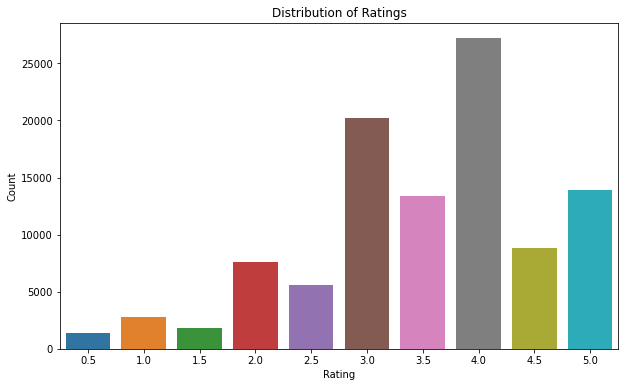

In [30]:
# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

##### Interpretation
The highest occuring rating is 4.0. 
This means that majority of the movies have a rating of 4.0.

The lowest occuring rating is 0.5. This means that only few movies have a rating of 0.5.


### Number of Ratings Per Movies

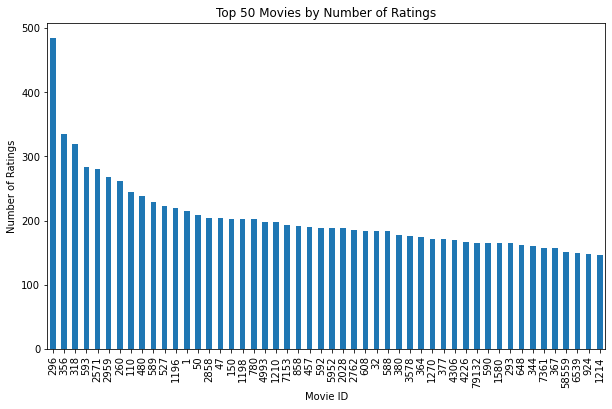

In [31]:
# ratings per movie
ratings_per_movie = df_final.groupby('movieId').size().sort_values(ascending=False)

# Plot the number of ratings per movie
plt.figure(figsize=(10, 6))
ratings_per_movie[:50].plot(kind='bar')
plt.title('Top 50 Movies by Number of Ratings')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.show()

MovieId 296 has the highest number of ratings at about 480.
This is an indication of most watched/liked by viewers
Other notable highly rated movies include movieId 356 and 318 which have over 300 total ratings.

### Most Rated Movies

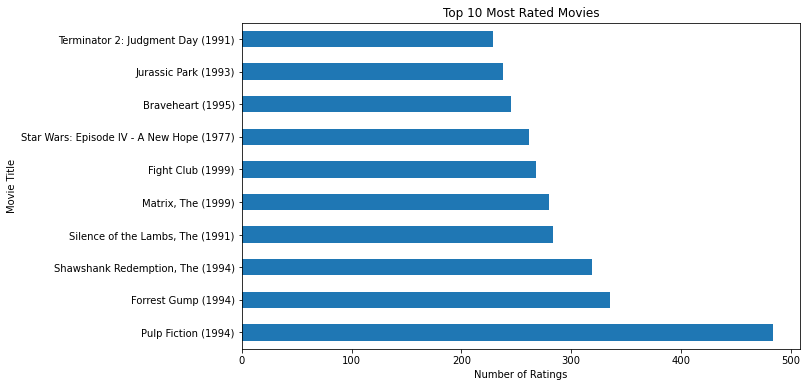

In [32]:
# Most rated movies
most_rated_movies = df_final.groupby('title').size().sort_values(ascending=False).head(10)

# plot
plt.figure(figsize=(10, 6))
most_rated_movies.plot(kind='barh')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

Pulp Fiction(1994) is the highest rated movie title by average rating. 
Other top rated movies include: Shawshank Redemention,The (1994), Forrest Gump(1994), Silence of the Lambs,The (1991), Matrix,The(1999).

#### Top 10 Most Frequent Movie Genres and Combinations

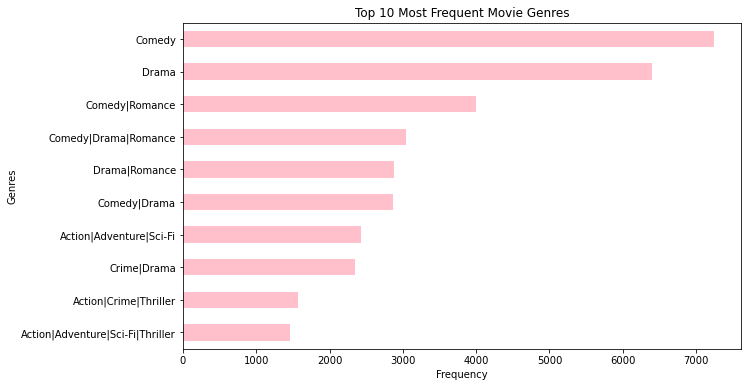

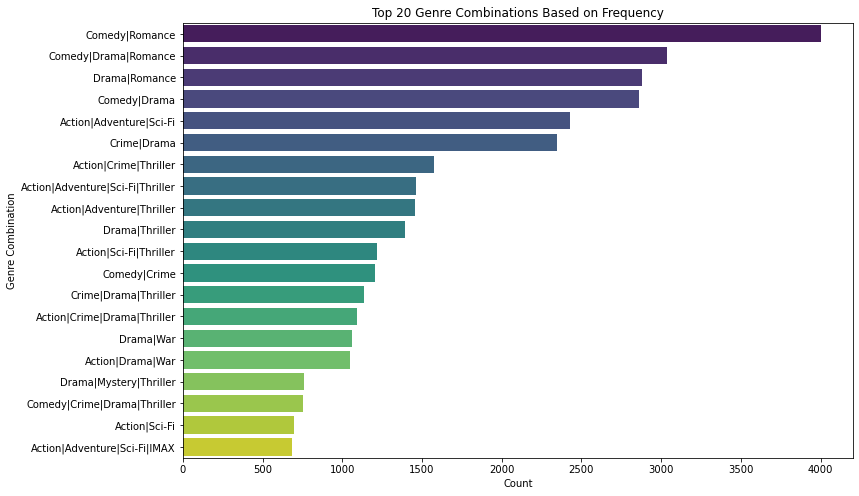

In [33]:
# Count plot for movie genres (showing top 10 most frequent genres)
plt.figure(figsize=(10, 6))
df_final['genres'].value_counts().head(10).plot(kind='barh', color='pink')
plt.title('Top 10 Most Frequent Movie Genres')
plt.xlabel('Frequency')
plt.ylabel('Genres')
plt.gca().invert_yaxis()  # Invert y-axis to show the most frequent genre on top
plt.show()



#Count of each genre combination
genre_combinations = df_final['genres'].value_counts().reset_index()
genre_combinations.columns = ['Genre Combination', 'Count']

# Filter out genre combinations that do not contain '|'
multi_genre_combinations = genre_combinations[genre_combinations['Genre Combination'].str.contains('\|')]

# Plotting the genre combination counts
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Genre Combination', data=multi_genre_combinations.head(20), palette='viridis')
plt.title('Top 20 Genre Combinations Based on Frequency')
plt.xlabel('Count')
plt.ylabel('Genre Combination')
plt.show()

Comedy is the most frequent movie genre with a frequency of about 7000.
Drama is the second frequent genre with a frequency of about  about 6500.
Comedy/Romance are most frequent combination with a frequency of 4000.
Other most prefferred combinations include Comedy/Drama/Romance, Drama/Romance

#### Count for Each Specific Genre

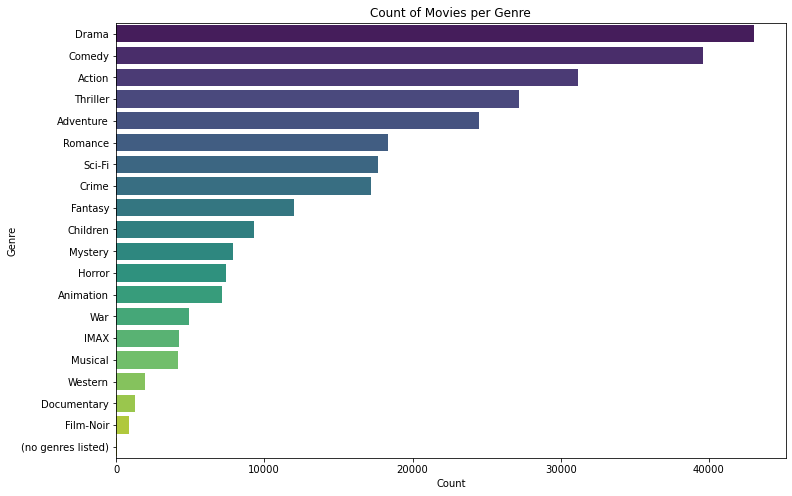

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting genres and exploding the list to have one genre per row
df_exploded = df_final.copy()
df_exploded['genres'] = df_exploded['genres'].str.split('|')
df_exploded = df_exploded.explode('genres')

# Count of each genre
genre_counts = df_exploded['genres'].value_counts()

# Plotting the genre counts
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Count of Movies per Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


Drama tops the list as the most highly like genre with over 40000 viewers.
Comedy is the second liked genre with about 38000 viewers
Action is the third liked genre with about 30000 viewers
Film-Noir is the least liked genre with only about 2000 viewers.

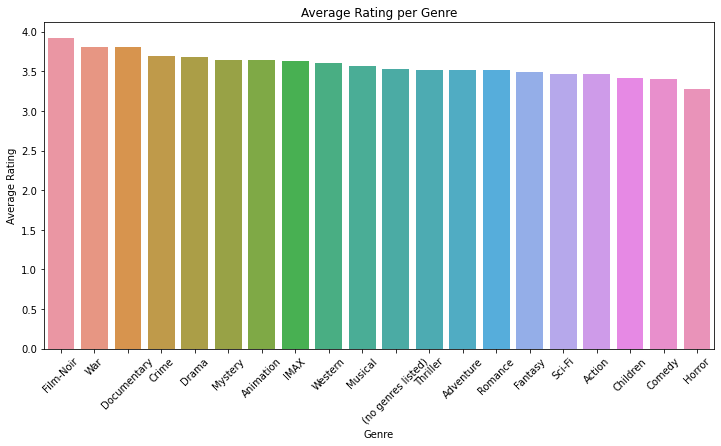

In [35]:
# Splitting genres and expanding into separate rows for analysis
df_exploded = df_final.copy()
df_exploded['genres'] = df_exploded['genres'].str.split('|')
df_exploded = df_exploded.explode('genres')

# Calculate the average rating for each genre
genre_rating = df_exploded.groupby('genres')['rating'].mean().sort_values(ascending=False)

# Plot the average rating per genre
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_rating.index, y=genre_rating.values)
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

#### Interpretation
On avaerge, genre Film-Noir has the highest rating at about 3.8.
Horror has the least rating on average at about 3.5.
However, this distribution  may not give better insights as the metric average in this case may higher due to fewer viewers rating such movies

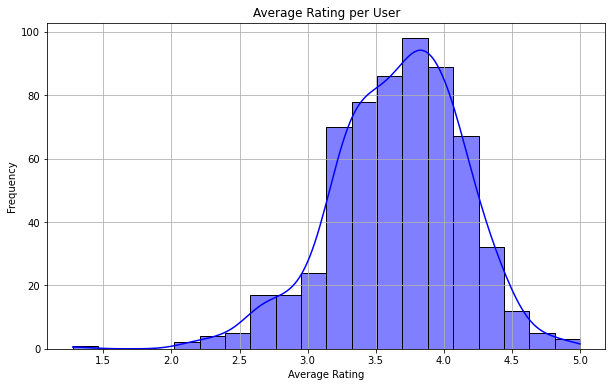

In [36]:
# Average rating per user
# This plot shows the distribution of average ratings given by users.

average_rating_per_user = df_final.groupby('userId')['rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.histplot(average_rating_per_user['rating'], bins=20, kde=True, color='blue')
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract unique years
unique_years = df_final['year'].unique()

# Sort the years
unique_years_sorted = sorted(unique_years)

# Display the unique years
print("Unique years in the dataset:")
print(unique_years_sorted)

Unique years in the dataset:
[0, 1902, 1903, 1908, 1915, 1916, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


#### Average Rating per Year

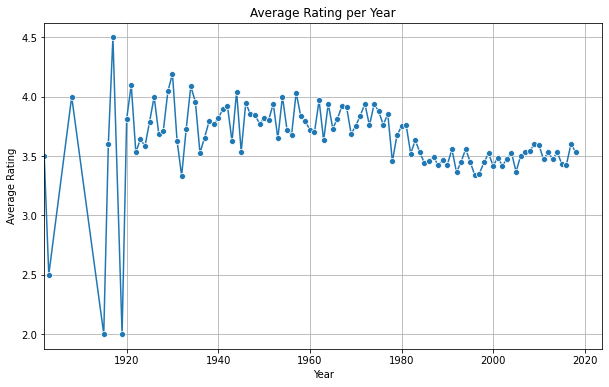

In [38]:
# Filter out the year 0 (Year 0 is a dummy year added to replace missing data in the year column)
df_filtered = df_final[df_final['year'] != 0]

# Calculate the average rating per year
average_rating_per_year = df_filtered.groupby('year')['rating'].mean().reset_index()

# Start with the earliest non-zero year
start_year = average_rating_per_year['year'].min()

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_rating_per_year, x='year', y='rating', marker='o')
plt.title('Average Rating per Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.xlim(start_year)
plt.show()

#### Interpretation
The highest average rating was 4.5 in around the year 1918.

The lowest average rating were in 2.0 around the years 1916 and 1919.

As the year progresses, the ratings showed stationary and almost a decreasing tend

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract unique years
unique_years = df_final['year'].unique()

# Sort the years
unique_years_sorted = sorted(unique_years)

# Display the unique years
print("Unique years in the dataset:")
print(unique_years_sorted)

Unique years in the dataset:
[0, 1902, 1903, 1908, 1915, 1916, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


### Average Rating Across Genres Over the Years

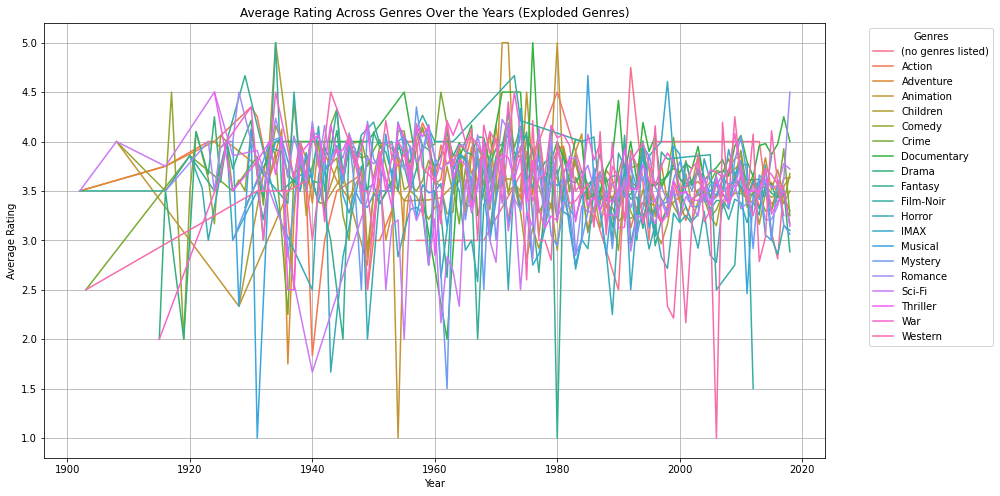

In [40]:
# Splitting genres into separate rows and exploding the dataframe
df_exploded_genres = df_filtered.assign(genres=df_filtered['genres'].str.split('|')).explode('genres')

# Recalculate average rating per genre per year after exploding genres
avg_rating_genre_year_exploded = df_exploded_genres.groupby(['genres', 'year'])['rating'].mean().reset_index()

# Plotting
plt.figure(figsize=(14, 8))
sns.lineplot(data=avg_rating_genre_year_exploded, x='year', y='rating', hue='genres')
plt.title('Average Rating Across Genres Over the Years (Exploded Genres)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#### Top 20 Highest Rated Movies

#### Interpretation

Pulp Fiction(1994) is the highest rated movie title by average rating.
Other top rated movies include: Shawshank Redemention,The (1994), Forrest Gump(1994), Silence of the Lambs,The (1991), Matrix,The(1999).


#### Rating by Top Genres

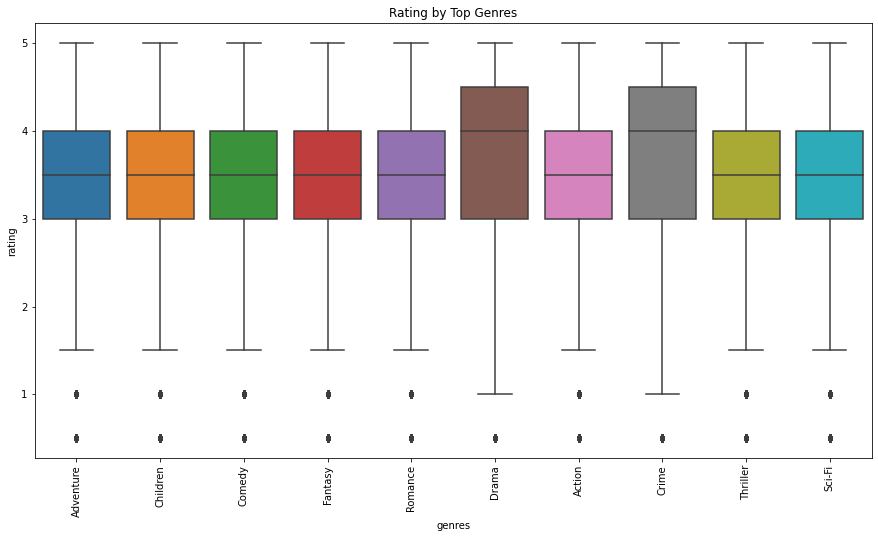

In [41]:
# Split genres into individual genres
df_final['genres'] = df_final['genres'].str.split('|')
df_final = df_final.explode('genres')

# Count the frequency of each genre
genre_counts = df_final['genres'].value_counts()

# Select top 10 genres
top_n = 10
top_genres = genre_counts.nlargest(top_n).index

# Filter the DataFrame to include only top 10 genres
filtered_df = df_final[df_final['genres'].isin(top_genres)]

# Plot Rating vs. Top N Genres
plt.figure(figsize=(15, 8))
sns.boxplot(data=filtered_df, x='genres', y='rating')
plt.xticks(rotation=90)
plt.title('Rating by Top Genres')
plt.show()

#### Interpretation
Drama and crime are the top rated genres meaning that they are mostly watched by consumers since they have the highest median ratings.

other well rated genres include Adventure, Fastasy,Action,Thriller,Sci_Fi, Comedy among others

### Bivariant Analysis

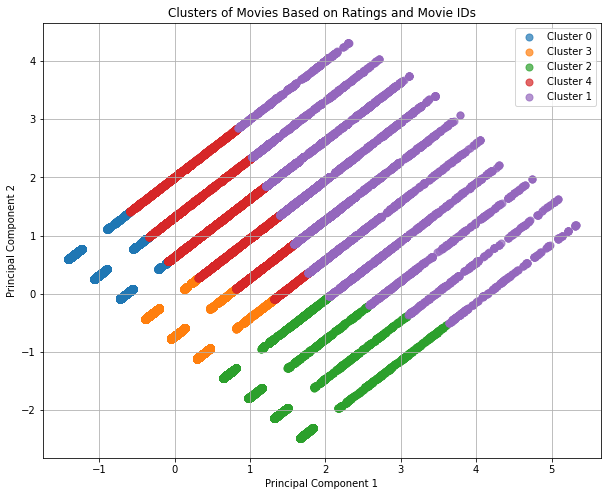

In [42]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# Create a copy of df_final to avoid modifying the original DataFrame
data = df_final.copy()  # Use parentheses to call the copy method

data = data[['rating', 'movieId']].dropna()  # Only numeric columns and drop any missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_pca)  # Use PCA data for clustering

# Create a DataFrame for the PCA results and the cluster labels
pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in pca_df['Cluster'].unique():
    plt.scatter(pca_df[pca_df['Cluster'] == cluster]['PC1'],
                pca_df[pca_df['Cluster'] == cluster]['PC2'],
                label=f'Cluster {cluster}', s=50, alpha=0.7)

plt.title('Clusters of Movies Based on Ratings and Movie IDs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

This is the natural groupings or patterns among the movies based on their ratings and IDs.

The movies exists in 5 clusters.

### Modelling

In [43]:

from surprise import Dataset, Reader, SVD
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np
from sklearn.utils.extmath import randomized_svd
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV

### User_based Collaborative Filtering. 

#### KNNBasic Model with Cosine Similarity

In [46]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
import pandas as pd

# Step 2: Prepare the Data
data = df_final[['userId', 'movieId', 'rating']]
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(data, reader)

# Step 3: Split the Data
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Build and Train the Model
sim_options = {
    'name': 'cosine',
    'user_based': True  # User-based collaborative filtering
}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Step 5: Make Recommendations
def get_top_n_recommendations(algo, user_id, n=5):
    # Get a list of all movie ids
    movie_ids = df_final['movieId'].unique()
    
    # Predict ratings for all movies not yet rated by the user
    user_rated_movies = df_final[df_final['userId'] == user_id]['movieId'].unique()
    movies_to_predict = [movie_id for movie_id in movie_ids if movie_id not in user_rated_movies]
    
    predictions = [algo.predict(user_id, movie_id) for movie_id in movies_to_predict]
    
    # Sort predictions by estimated rating
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Get the movie ids of the top predictions
    top_movie_ids = [pred.iid for pred in top_predictions]
    
    # Get the movie titles for the top predictions
    top_movie_titles = df_final[df_final['movieId'].isin(top_movie_ids)][['movieId', 'title']].drop_duplicates()
    
    return top_movie_titles

# Getting top 5 recommendations for user with userId = 50
user_id = 50
top_5_recommendations = get_top_n_recommendations(algo, user_id, n=5)
print("Top 5 movie recommendations for user {}: \n".format(user_id))
print(top_5_recommendations)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Top 5 movie recommendations for user 50: 

       movieId                                              title
2639        53                                    Lamerica (1994)
3218        99               Heidi Fleiss: Hollywood Madam (1995)
4091       148                   Awfully Big Adventure, An (1995)
13187      467                             Live Nude Girls (1995)
13823      495  In the Realm of the Senses (Ai no corrida) (1976)


### Model Evaluaution

In [47]:
# Evaluate the model
predictions = algo.test(testset)
print("Accuracy: ", accuracy.rmse(predictions))

RMSE: 0.8389
Accuracy:  0.8389374025272407


### KNNBaseline with Pearson Similarity and Bias Term

In [48]:
## Adding a bias term
sim_pearson = {"name": "pearson", "user_based": True}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6533
0.653326832327644


 A bias term introduced on the about model to account for user and item biases.
 
 This has improved the model's performance from initial RMSE: 0.8426 to a new RMSE: 0.6530

#### Evaluating performance of KNNBaseline Model

In [49]:
from surprise import KNNBaseline, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import numpy as np

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_final[['userId', 'movieId', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Define similarity options and train the KNNBaseline model
sim_pearson = {"name": "pearson", "user_based": True}
knn_baseline = KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)

# Predict ratings on the test set
predictions = knn_baseline.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

# Calculate MAE
mae = accuracy.mae(predictions)
print(f"MAE: {mae}")

# Function to calculate precision and recall at k
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    # Map the predictions to each user.
    user_est_true = {}
    for uid, _, true_r, est, _ in predictions:
        if uid not in user_est_true:
            user_est_true[uid] = []
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

# Calculate precision and recall at k
precision, recall = precision_recall_at_k(predictions, k=5)
print(f"Precision@K: {precision}")
print(f"Recall@K: {recall}")

# Calculate coverage
all_items = set(trainset.all_items())
predicted_items = set([pred.iid for pred in predictions])
coverage = len(predicted_items) / len(all_items)
print(f"Coverage: {coverage}")

# You can also print out some of the predictions
print("\nSome of the predictions:")
for uid, iid, true_r, est, _ in predictions[:10]:
    print(f"User: {uid}, Item: {iid}, True Rating: {true_r}, Predicted Rating: {est}")

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6583
RMSE: 0.6583058948541813
MAE:  0.4828
MAE: 0.48284113825714603
Precision@K: 0.9632240437158471
Recall@K: 0.21373735013548373
Coverage: 0.7593571351526265

Some of the predictions:
User: 34, Item: 10, True Rating: 5.0, Predicted Rating: 3.6918426866152627
User: 605, Item: 3489, True Rating: 3.5, Predicted Rating: 3.075479338358731
User: 590, Item: 41569, True Rating: 3.5, Predicted Rating: 3.2166557432549476
User: 517, Item: 593, True Rating: 3.0, Predicted Rating: 3.160795874781198
User: 62, Item: 122886, True Rating: 4.0, Predicted Rating: 3.7766501253361224
User: 509, Item: 106072, True Rating: 3.5, Predicted Rating: 3.0553017805004004
User: 204, Item: 858, True Rating: 4.0, Predicted Rating: 4.738781096498638
User: 489, Item: 4014, True Rating: 3.5, Predicted Rating: 3.3391922279758197
User: 33, Item: 2542, True Rating: 4.0, Predicted Rating: 4.185868298057456
Use

On evaluations, the model performs as below:

RMSE: 0.6583.Which shows the model’s predictions are fairly accurate with an average error of 0.6583 on the rating scale.

MAE:  0.4828.Indicating the average prediction error is 0.4828, which is lower than RMSE because it doesn't penalize larger errors as strongly.

Precision: 0.9632240437158471.Meaning 96.32% of the top 5 recommended items are relevant

Recall: 0.21

Coverage: 0.76. This means that the model is able to make 75% recommendations to a user.

### KNN with Means

In [50]:
sim_pearson = {"name": "pearson", "user_based": True}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6730
0.6729891990980613


KNNWith Means has a slightly higher RMSE: 0.6730 than KNNBaseline Model which has a RMSE: 0.6583.
Meaning that KNNBaseline Model perfomance better in this scenario.

## Model-Based Methods (Matrix Factorization:Application of SVD)

In [51]:
# Step 1: Install and Import Required Libraries
!pip install scikit-surprise

import pandas as pd
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

# Step 2: Prepare the Data
data = df_final[['userId', 'movieId', 'rating']]
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(data, reader)

# Step 3: Split the Data
trainset, testset = train_test_split(data, test_size=0.2)

# Using the provided hyperparameters directly
svd = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.4)
svd.fit(trainset)

# Evaluate the Model
predictions = svd.test(testset)
print("RMSE:", accuracy.rmse(predictions))


RMSE: 0.8549
RMSE: 0.854949174541152


### Model Evaluation

In [52]:
{'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV

# param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs_model = GridSearchCV(SVD,param_grid=param_grid,n_users = -1,ratings_verbose=5)
# gs_model.fit(jokes)
svd = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.4)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8549
0.854922452899806


##### SVD model has an RMSE: 0.8602 which is a poor performance than previous KNNBasic and KNNWith Means

#### Identify Best Performing Model

In [54]:
!pip install scikit-surprise

import pandas as pd
from surprise import Dataset, Reader, KNNBasic, KNNWithMeans, KNNBaseline, SVD, accuracy
from surprise.model_selection import train_test_split

# Prepare the data
data = df_final[['userId', 'movieId', 'rating']]
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(data, reader)

# Split the data
trainset, testset = train_test_split(data, test_size=0.2)

# Define and train the KNNBasic Model with Cosine Similarity
sim_options_cosine = {
    'name': 'cosine',
    'user_based': True  # User-based collaborative filtering
}
knn_basic_algo = KNNBasic(sim_options=sim_options_cosine)
knn_basic_algo.fit(trainset)
knn_basic_predictions = knn_basic_algo.test(testset)
knn_basic_rmse = accuracy.rmse(knn_basic_predictions)
print(f"KNNBasic RMSE: {knn_basic_rmse}")

# Define and train the KNNBaseline Model with Pearson Similarity
sim_options_pearson = {
    'name': 'pearson',
    'user_based': True  # User-based collaborative filtering
}
knn_baseline_algo = KNNBaseline(sim_options=sim_options_pearson)
knn_baseline_algo.fit(trainset)
knn_baseline_predictions = knn_baseline_algo.test(testset)
knn_baseline_rmse = accuracy.rmse(knn_baseline_predictions)
print(f"KNNBaseline RMSE: {knn_baseline_rmse}")

# Define and train the KNNWithMeans Model with Pearson Similarity
knn_with_means_algo = KNNWithMeans(sim_options=sim_options_pearson)
knn_with_means_algo.fit(trainset)
knn_with_means_predictions = knn_with_means_algo.test(testset)
knn_with_means_rmse = accuracy.rmse(knn_with_means_predictions)
print(f"KNNWithMeans RMSE: {knn_with_means_rmse}")

# Define and train the Model-Based Methods (Matrix Factorization) with SVD
svd_algo = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.4)
svd_algo.fit(trainset)
svd_predictions = svd_algo.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)
print(f"SVD RMSE: {svd_rmse}")

# Determine the best model based on RMSE
model_rmse = {
    'KNNBasic': knn_basic_rmse,
    'KNNBaseline': knn_baseline_rmse,
    'KNNWithMeans': knn_with_means_rmse,
    'SVD': svd_rmse
}

best_model = min(model_rmse, key=model_rmse.get)
print(f"The best performing model is {best_model} with an RMSE of {model_rmse[best_model]}")


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8434
KNNBasic RMSE: 0.843420958584143
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6537
KNNBaseline RMSE: 0.6537291446565463
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6673
KNNWithMeans RMSE: 0.6673048470894625
RMSE: 0.8562
SVD RMSE: 0.8561978380832317
The best performing model is KNNBaseline with an RMSE of 0.6537291446565463


##### The best performing model is KNNBaseline with an RMSE of  0.66

## Hyperparameter Tuning on KNNBaseline Model

In [55]:
from surprise import KNNBaseline, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split

# Define the parameter grid for KNNBaseline
param_grid = {
    'k': [10, 20, 30],  # Number of neighbors
    'min_k': [1, 5, 10],  # Minimum number of neighbors
    'sim_options': {
        'name': ['pearson', 'cosine'],
        'user_based': [True]  # User-based collaborative filtering
    }
}

# Perform Grid Search
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)  # Fit on the Dataset object

# Get the best model and parameters
best_model = gs.best_estimator['rmse']
print("Best RMSE: ", gs.best_score['rmse'])
print("Best parameters: ", gs.best_params['rmse'])

# Train-test split
trainset, testset = train_test_split(data, test_size=0.25)

# Fit the best model on the trainset
best_model.fit(trainset)

# Test the model on the testset
predictions = best_model.test(testset)

# Calculate RMSE
print(accuracy.rmse(predictions))


Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


#### Evaluating tune KNNBaseline Model

In [56]:
from surprise import KNNBaseline, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Define the parameter grid for KNNBaseline
param_grid = {
    'k': [10, 20, 30],  # Number of neighbors
    'min_k': [1, 5, 10],  # Minimum number of neighbors
    'sim_options': {
        'name': ['pearson', 'cosine'],
        'user_based': [True]  # User-based collaborative filtering
    }
}

# Perform Grid Search
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)  # Fit on the Dataset object

# Get the best model and parameters
best_model = gs.best_estimator['rmse']
print("Best RMSE: ", gs.best_score['rmse'])
print("Best parameters: ", gs.best_params['rmse'])

# Train-test split
trainset, testset = train_test_split(data, test_size=0.25)

# Fit the best model on the trainset
best_model.fit(trainset)

# Test the model on the testset
predictions = best_model.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)
print("RMSE: ", rmse)

# Convert predictions to a DataFrame
pred_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'true_rating', 'est', 'details'])

# Define a threshold to classify predictions as relevant or not
threshold = 3.5  # Adjust this based on your criteria
pred_df['predicted'] = pred_df['est'].apply(lambda x: 1 if x >= threshold else 0)
pred_df['actual'] = pred_df['true_rating'].apply(lambda x: 1 if x >= threshold else 0)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(pred_df['actual'], pred_df['predicted'], average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


KNNBaseline (Before Tuning): RMSE = 0.66
    
Tuned KNNBaseline:RMSE: 0.61
        
The fine-tuned KNNBaseline model provides the best prediction accuracy among the models you have tested,

with the lowest RMSE value of 0.61

### Top 5 Movie Recommendations Based on tuned KNN Baseline Model

In [57]:
import pandas as pd
from surprise import Dataset, Reader, KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare the data
data = df_final[['userId', 'movieId', 'rating']]
reader = Reader(rating_scale=(0.5, 5.0))
dataset = Dataset.load_from_df(data, reader)

# Rebuild the trainset with the entire dataset
trainset = dataset.build_full_trainset()

# Load the best model
best_knn_with_means = KNNWithMeans(k=10, min_k=1, sim_options={'name': 'pearson', 'user_based': True})
best_knn_with_means.fit(trainset)

# Get the list of all movies
all_movie_ids = set(df_final['movieId'].unique())

# Function to recommend top N movies for a specific user
def recommend_top_n_movies(predictions, n=5):
    # Map predictions to a DataFrame
    predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'true_rating', 'est', 'details'])
    
    # Group by user and get the top N movies with highest predicted rating
    top_n = predictions_df.groupby('uid').apply(lambda x: x.sort_values(by='est', ascending=False).head(n)).reset_index(drop=True)
    
    return top_n

# Function to get movie predictions for a specific user
def get_movie_predictions(user_id, model, trainset, all_movie_ids):
    # Convert user_id to inner ID
    inner_uid = trainset.to_inner_uid(user_id)
    
    # Get the list of movies that the user has rated
    rated_movie_ids = set(movie_id for (movie_id, _) in trainset.ur[inner_uid])
    
    # Get the list of movies that the user has not rated
    unrated_movie_ids = all_movie_ids - rated_movie_ids
    
    # Predict ratings for the unrated movies
    predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movie_ids]
    
    return predictions

# Showmax Predictions
user_id = 50  # Replace with the actual user ID

# Get predictions for the user
predictions = get_movie_predictions(user_id, best_knn_with_means, trainset, all_movie_ids)

# Recommend top 5 movies
top_n_movies = recommend_top_n_movies(predictions, n=5)
print(top_n_movies[['uid', 'iid', 'est']])


Computing the pearson similarity matrix...
Done computing similarity matrix.
   uid     iid                est
0   50  132333 4.8292211014563211
1   50    5490 4.8292211014563211
2   50   40491 4.7325962588425199
3   50   25947 4.6931421864520457
4   50    3508 4.5857646825512965


In [68]:
# List of recommended movie IDs
recommended_movie_ids = [50]

# Filter df_final to get the titles of the recommended movies
recommended_movies = df_final[df_final['movieId'].isin(recommended_movie_ids)][['movieId', 'title']]

print(recommended_movies)


      movieId                       title
2402       50  Usual Suspects, The (1995)
2402       50  Usual Suspects, The (1995)
2402       50  Usual Suspects, The (1995)
2403       50  Usual Suspects, The (1995)
2403       50  Usual Suspects, The (1995)
2403       50  Usual Suspects, The (1995)
2404       50  Usual Suspects, The (1995)
2404       50  Usual Suspects, The (1995)
2404       50  Usual Suspects, The (1995)
2405       50  Usual Suspects, The (1995)
2405       50  Usual Suspects, The (1995)
2405       50  Usual Suspects, The (1995)
2406       50  Usual Suspects, The (1995)
2406       50  Usual Suspects, The (1995)
2406       50  Usual Suspects, The (1995)
2407       50  Usual Suspects, The (1995)
2407       50  Usual Suspects, The (1995)
2407       50  Usual Suspects, The (1995)
2408       50  Usual Suspects, The (1995)
2408       50  Usual Suspects, The (1995)
2408       50  Usual Suspects, The (1995)
2409       50  Usual Suspects, The (1995)
2409       50  Usual Suspects, The

Based on the previous user preferances,

KNN Baseline Model tuned model was able to make below Top 5 Movie Recommendations.

### Hybrid Approach

In [59]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Function to train the collaborative filtering model
def train_cf_model(df_final):
    # Step 1: Define the Reader object specifying the rating scale
    reader = Reader(rating_scale=(0.5, 5))
    
    # Step 2: Load the dataset into a Surprise Dataset object
    data = Dataset.load_from_df(df_final[['userId', 'movieId', 'rating']], reader)
    
    # Step 3: Split the data into train and test sets
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)
    
    # Step 4: Build the SVD model using the best parameters from hyperparameter tuning
    model = SVD(n_factors=50, reg_all=0.05)
    
    # Step 5: Train the model on the entire training set
    model.fit(trainset)
    
    return model, trainset, testset
# Function to generate collaborative filtering recommendations
def generate_cf_recommendations(user_id, df_final, cf_model):
    # Filter out movies already rated by the user
    user_movies = df_final[df_final['userId'] == user_id]['movieId'].unique()
    movies_to_predict = df_final[~df_final['movieId'].isin(user_movies)]['movieId'].unique()
    
    # Get predictions for the user from collaborative filtering
    user_predictions = []
    for movie_id in movies_to_predict:
        predicted_rating = cf_model.predict(user_id, movie_id).est
        user_predictions.append((movie_id, predicted_rating))
    
    # Sort predictions by estimated rating
    user_predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Return top N recommendations (e.g., top 5)
    top_n = 5
    cf_recommendations = user_predictions[:top_n]
    
    return cf_recommendations
# Function to calculate RMSE on the test set
def calculate_rmse(model, testset):
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    return rmse
# Train the collaborative filtering model
cf_model, trainset, testset = train_cf_model(df_final)

# Calculate RMSE on the test set
print(f"RMSE on test set: {calculate_rmse(cf_model, testset)}")

RMSE: 0.6618
RMSE on test set: 0.6617818721122518


In [60]:
# Generate recommendations for a user
user_id = int(input("Enter user ID: "))
cf_recommendations = generate_cf_recommendations(user_id, df_final, cf_model)
print(f"Top 5 Recommendations for User {user_id}:")
for i, rec in enumerate(cf_recommendations, 1):
    movie_id, predicted_rating = rec
    movie_title = df_final[df_final['movieId'] == movie_id]['title'].iloc[0]
    print(f"Recommendation #{i}: MovieID {movie_id}, Predicted Rating: {predicted_rating}, Title: {movie_title}")

Enter user ID: 50
Top 5 Recommendations for User 50:
Recommendation #1: MovieID 3030, Predicted Rating: 3.8813257906398535, Title: Yojimbo (1961)
Recommendation #2: MovieID 3266, Predicted Rating: 3.671573303461218, Title: Man Bites Dog (C'est arrivé près de chez vous) (1992)
Recommendation #3: MovieID 908, Predicted Rating: 3.6553880602043143, Title: North by Northwest (1959)
Recommendation #4: MovieID 31364, Predicted Rating: 3.639759290647506, Title: Memories of Murder (Salinui chueok) (2003)
Recommendation #5: MovieID 527, Predicted Rating: 3.6314736093960116, Title: Schindler's List (1993)


### Item_based Filtering

### SVD Model

In [63]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate the cosine similarity (sorting by most similar and returning the top N)
def top_cosine_similarity(data, movieId, top_n=5):
    index = movieId_to_index[movieId]  # Use the mapping to get the correct index
    movie_row = data[index, :]
    similarity = cosine_similarity(movie_row.reshape(1, -1), data).flatten()
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

# Function to print top N similar movies 
def print_similar_movies(movie_df, movieId, top_indexes):
    movie_name = movie_df[movie_df.movieId == movieId].title.values
    if movie_name.size > 0:
        print(f"Recommendations for {movie_name[0]}: \n")
    else:
        print(f"Movie ID {movieId} not found in the dataset.\n")
        return

    for idx in top_indexes:
        similar_movie_id = index_to_movieId[idx]
        similar_movie_name = movie_df[movie_df.movieId == similar_movie_id].title.values
        if similar_movie_name.size > 0:
            print(similar_movie_name[0])
        else:
            print(f"Similar movie ID {similar_movie_id} not found in the dataset.")

# Aggregate ratings to avoid duplicates
df_final_agg = df_final.groupby(['userId', 'movieId'])['rating'].mean().reset_index()

# Pivot the data to create a user-item matrix
user_item_matrix = df_final_agg.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Create mappings between movie IDs and matrix indices
movieId_to_index = {movieId: index for index, movieId in enumerate(user_item_matrix.columns)}
index_to_movieId = {index: movieId for index, movieId in enumerate(user_item_matrix.columns)}

# Apply SVD to reduce dimensionality
svd = TruncatedSVD(n_components=50)
V = svd.fit_transform(user_item_matrix.T)

# Number of principal components to represent movies, movie_id to find recommendations, top_n print n results        
k = 50
movieId = 5  # (getting an id from movies.dat)
top_n = 5

# Use the first k principal components
sliced = V[:, :k]  # representative data

# Get the indexes of the top N similar movies
indexes = top_cosine_similarity(sliced, movieId, top_n)

# Printing the top N similar movies
print_similar_movies(df_final, movieId, indexes)


Recommendations for Father of the Bride Part II (1995): 

Father of the Bride Part II (1995)
Sabrina (1995)
River Wild, The (1994)
Broken Arrow (1996)
Stupids, The (1996)


##### Model Evaluation

In [64]:
from surprise import SVD

from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

In [65]:
# Aggregate ratings to avoid duplicates
df_final_agg = df_final.groupby(['userId', 'movieId'])['rating'].mean().reset_index()

# Prepare the data for Surprise library
reader = Reader(rating_scale=(df_final_agg['rating'].min(), df_final_agg['rating'].max()))
data = Dataset.load_from_df(df_final_agg[['userId', 'movieId', 'rating']], reader)

# Use the SVD algorithm for collaborative filtering
algo = SVD()

# Run 5-fold cross-validation and print results
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print mean RMSE and MAE
print(f"Mean RMSE: {results['test_rmse'].mean()}")
print(f"Mean MAE: {results['test_mae'].mean()}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8790  0.8714  0.8757  0.8746  0.8691  0.8740  0.0034  
MAE (testset)     0.6772  0.6711  0.6756  0.6693  0.6655  0.6718  0.0042  
Fit time          6.36    7.13    6.04    6.10    6.03    6.33    0.41    
Test time         0.14    0.43    0.14    0.14    0.16    0.20    0.11    
Mean RMSE: 0.8739746475971643
Mean MAE: 0.6717606678568748


###### SVD algorithim performed as follows on the item_based filtering:
    
Mean RMSE: 0.87

MAE:  0.67

Meaning that on average, the model's predictions deviate from the actual ratings by about 0.87 points on the rating scale

#### Optimisation and Tuning

In [66]:
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV, cross_validate


# Aggregate ratings to avoid duplicates
df_final_agg = df_final.groupby(['userId', 'movieId'])['rating'].mean().reset_index()
print("Aggregated ratings data:")
print(df_final_agg.head())

# Prepare the data for Surprise library
reader = Reader(rating_scale=(df_final_agg['rating'].min(), df_final_agg['rating'].max()))
data = Dataset.load_from_df(df_final_agg[['userId', 'movieId', 'rating']], reader)
print("Data prepared for Surprise library.")

# Define a parameter grid for the SVD model
param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}

# Perform grid search to find the best hyperparameters
print("Starting grid search...")
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)  # Removed verbose=True
try:
    gs.fit(data)
except Exception as e:
    print(f"An error occurred during grid search: {e}")

print("Grid search completed.")

# Print best score and best parameters
print(f"Best RMSE score: {gs.best_score['rmse']}")
print(f"Best parameters: {gs.best_params['rmse']}")

# Train the model with the best parameters
best_algo = gs.best_estimator['rmse']
print("Training model with best parameters...")

# Run 5-fold cross-validation and print results
try:
    results = cross_validate(best_algo, data, measures=['RMSE', 'MAE'], cv=5)
    print(f"Mean RMSE: {results['test_rmse'].mean()}")
    print(f"Mean MAE: {results['test_mae'].mean()}")
except Exception as e:
    print(f"An error occurred during cross-validation: {e}")


Aggregated ratings data:
   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0
Data prepared for Surprise library.
Starting grid search...
Grid search completed.
Best RMSE score: 0.8517009916124121
Best parameters: {'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}
Training model with best parameters...
Mean RMSE: 0.8515891119192964
Mean MAE: 0.6527309390411189


### Findings 

### 1. User Based Collaborative Filtering

#### Best Model: KNN Baseline Model

#### Interpretation of Results:
The KNNBaseline model provided accurate recommendations with higher predicted ratings and lower RMSE, suggesting it may be more effective in recommending top movies compared to KNNwith Mean and SVD

KNNBaseline (Before Tuning): RMSE = 0.66
    
Tuned KNNBaseline:RMSE: 0.61

Precision:  0.90

Recall:  0.79

F1 Score:  0.85

The KNNBaseline model successfully recommended top 5 movies for users, considering both predicted ratings and similar movie suggestions. 

The model has high accuracy F1 Score:  0.85 suggesting a  best model performing model.

#### Conclusions
The tuned KNNBaseline model is more effective in predicting user preferences compared to the initial model.
Improved predictive accuracy translates to more relevant and personalized movie recommendations for users.

### Recommendations:
Use the KNNBaseline model's recommendations to personalize user experience on Showmax. This can help in engaging users by suggesting movies they are likely to enjoy based on their past ratings.

Generate Top 5 Recommendations: Use the tuned model to predict ratings and recommend the top 5 movies for each user based on their past ratings and viewing behaviors.

Monitor and Retrain: Regularly tune and evaluate the recommendation models with new data to ensure they adapt to changing user preferences and movie trends. This will help maintain the accuracy and relevance of recommendations.

Enhance User Engagement: Focus on user feedback and engagement metrics to refine and improve the recommendation system, ensuring high user satisfaction and retention.

### 2. Item_based Collaborative Filtering

#### Findings:

Achieved a mean RMSE of  0.85.

Mean MAE: 0.65

This is a higher RMSE compared to the KNNBaseline model suggesting lower prediction accuracy.

####  Recommendations:

Consider Hybrid Approaches:Combine item-based and user-based methods to leverage strengths of both, potentially improving recommendation accuracy and coverage.
 

#### Conclusions:
The item-based collaborative filtering model, while useful, demonstrated lower accuracy compared to the KNNBaseline model done on the user based collaborative filtering.

Integrating it with other methods or using hybrid approaches could enhance the recommendation system’s performance on Showmax.